## Imports

In [251]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

# Processing Optimal results

In [252]:
large = False
if large:
    path = "/large"
else:
    path = ""

all_players = pd.read_csv("../data/optim-data" + path + "/0_selection_players.csv", index_col=0)
n_players = all_players.shape[0]

with open("../data/optim-data" + path + "/optim_solution.json", "r") as fp:
    solution = json.load(fp)
    fp.close()

solution_variables = solution['CPLEXSolution']['variables']
solution_variables = [(x['name'], float(x['value'])) for x in solution_variables]

In [253]:
def get_players(variables, identifier):
    # assign, lentout, borrowed
    players = [x[0] for x in variables if identifier in x[0]]
    players = [x.split("_")[1:] for x in players]
    
    return players

def get_player_info(all_players, players, info):
    return [all_players.loc[int(i), info] for i in players]

assigned = pd.DataFrame(get_players(solution_variables, 'assign'), columns = ['Player', 'Year'])
lentout = pd.DataFrame(get_players(solution_variables, 'lentout'), columns = ['Player', 'Year'])
borrowed = pd.DataFrame(get_players(solution_variables, 'borrowed'), columns = ['Player', 'Year'])

players = sorted(np.unique(np.concatenate([assigned.Player, lentout.Player, borrowed.Player])), key=lambda x: int(x))
player_name = get_player_info(all_players, players, 'Player')
ages = get_player_info(all_players, players, 'Age')
raritan = get_player_info(all_players, players, 'Raritan')
player_gk = get_player_info(all_players, players, 'GK')
player_fw = get_player_info(all_players, players, 'FW')
player_mf = get_player_info(all_players, players, 'MF')
player_df = get_player_info(all_players, players, 'DF')

In [254]:
def fill_assignment(assignment, variables, fill_val):
    
    for index, (playerid, year) in variables.iterrows():
        year_s = "Year" + str(year)
        assignment.loc[playerid, year_s] = fill_val
        
    return

years = ['Year' + str(x) for x in range(10)]
assignment = pd.DataFrame(np.full((10, len(players)), np.nan)).T
assignment.columns = years
assignment.index = players

fill_assignment(assignment, assigned, 'o')
fill_assignment(assignment, lentout, 'l')
fill_assignment(assignment, borrowed, 'b')

assignment

,Year0,Year1,Year2,Year3,Year4,Year5,Year6,Year7,Year8,Year9
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,l
33,o,o,o,o,o,o,o,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,l
103,o,o,o,o,o,o,o,o,o,o
126,NaN,NaN,NaN,b,b,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2339,NaN,NaN,NaN,NaN,NaN,l,NaN,l,l,NaN
2340,l,l,l,l,l,NaN,l,l,l,NaN
2381,l,l,l,l,l,l,l,l,l,NaN
2411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b,b,b


In [255]:
player_info = pd.DataFrame([players, player_name, ages, raritan, player_gk, player_fw, player_mf, player_df]).T
player_info.columns = ["PlayerID", "Player", "Age0", "Raritan", 'GK', 'FW', 'MF', 'DF']
player_info.index = players
player_info

,PlayerID,Player,Age0,Raritan,GK,FW,MF,DF
11,11,a.baguma,18,1,0,1,0,0
33,33,a.hasibuan,26,1,0,0,0,1
68,68,a.nanjala,21,1,0,1,0,0
103,103,a.tindimwebwa,20,1,0,1,0,0
126,126,b.awio,18,0,1,0,0,0
...,...,...,...,...,...,...,...,...
2339,2339,y.thungu,22,1,0,0,0,1
2340,2340,y.torres,24,1,0,0,1,0
2381,2381,z.knezevi,28,1,0,1,0,0
2411,2411,z.rojas,21,0,0,0,0,1


In [256]:
player_selection = player_info.join(assignment, on='PlayerID')
player_selection
player_selection.to_excel("../data/optim-data" + path + "/selection.xlsx")


# Visualising Results

In [257]:
player_assignment_year = [player_selection.loc[:, year_s] for year_s in years]

/var/folders/32/t9xqcq814y79bs78xcmy806w0000gn/T/ipykernel_45779/4170680884.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(abs(tick)) for tick in ticks])


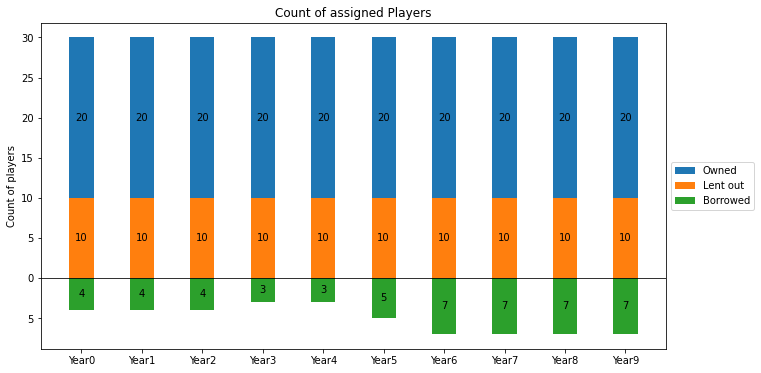

In [258]:
player_counts_year = [(np.sum(x == "o"), np.sum(x == "l"), np.sum(x == "b")) for x in player_assignment_year]

owned = [x[0] for x in player_counts_year]
lent = [x[1] for x in player_counts_year]
borrowed = [-x[2] for x in player_counts_year]

width = 0.4

fig, ax = plt.subplots()

fig.set_figheight(6)
fig.set_figwidth(14)

p1 = ax.bar(years, owned, width, bottom=lent,label='Owned')
p2 = ax.bar(years, lent, width, label='Lent out')
p3 = ax.bar(years, borrowed, width, label='Borrowed')

ax.set_ylabel('Count of players')
ax.set_title('Count of assigned Players')
ax.axhline(0, color='black', linewidth=0.8)

# Label with label_type 'center' instead of the default 'edge'
ax.bar_label(p1, label_type='center')
ax.bar_label(p2, label_type='center')
ax.bar_label(p3, label_type='center', labels=[-x for x in borrowed])

ticks =  ax.get_yticks()
# set labels to absolute values and with integer representation
ax.set_yticklabels([int(abs(tick)) for tick in ticks])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


/var/folders/32/t9xqcq814y79bs78xcmy806w0000gn/T/ipykernel_45779/374270121.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(abs(tick/1000000))) + "m" for tick in ticks])


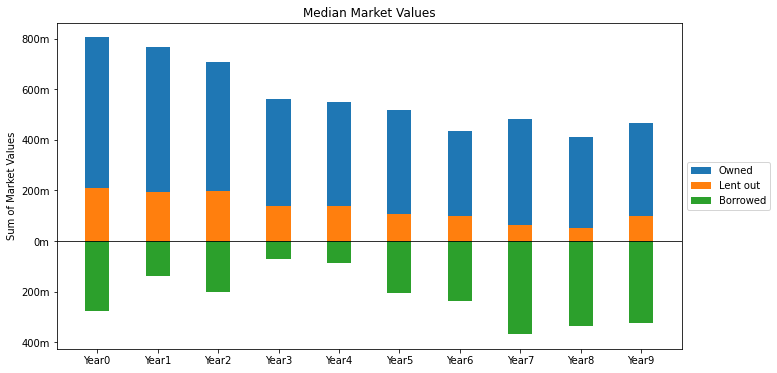

In [259]:
market_values = pd.read_csv("../data/optim-data/0_selection_mv.csv", index_col=0,).drop(['player_id', 'trial'], axis=1).values
n_time = market_values.shape[1]
n_trials = int(market_values.shape[0]/n_players)
market_values = np.median(market_values.reshape((n_trials, n_players, n_time)), axis=0)

owned = [sum([market_values[int(playerid), year] for playerid, asm in row.iteritems() if asm == 'o']) for year, row in enumerate(player_assignment_year)]
lent = [sum([market_values[int(playerid), year] for playerid, asm in row.iteritems() if asm == 'l']) for year, row in enumerate(player_assignment_year)]
borrowed = [-sum([market_values[int(playerid), year] for playerid, asm in row.iteritems() if asm == 'b']) for year, row in enumerate(player_assignment_year)]

width = 0.4

fig, ax = plt.subplots()

fig.set_figheight(6)
fig.set_figwidth(14)

p1 = ax.bar(years, owned, width, bottom=lent,label='Owned')
p2 = ax.bar(years, lent, width, label='Lent out')
p3 = ax.bar(years, borrowed, width, label='Borrowed')

ax.set_ylabel('Sum of Market Values')
ax.set_title('Median Market Values')
ax.axhline(0, color='black', linewidth=0.8)

# Label with label_type 'center' instead of the default 'edge'
# ax.bar_label(p1, label_type='center')
# ax.bar_label(p2, label_type='center')
# ax.bar_label(p3, label_type='center', labels=[-x for x in borrowed])

ticks =  ax.get_yticks()
# set labels to absolute values and with integer representation
ax.set_yticklabels([str(int(abs(tick/1000000))) + "m" for tick in ticks])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

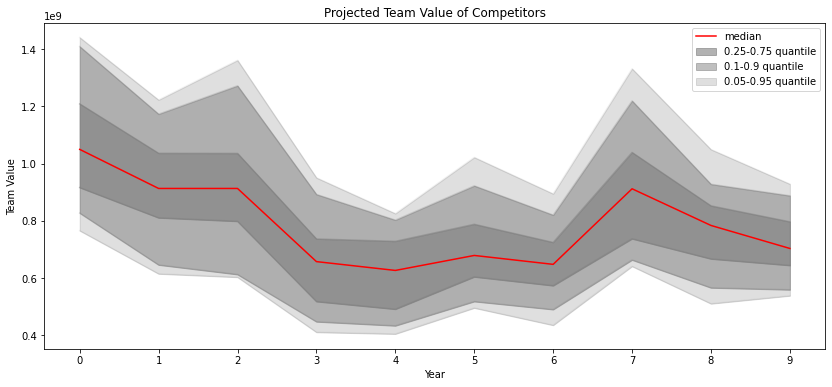

In [260]:
team_values = np.full((n_trials, n_time), np.nan)

for variable, val in solution_variables:
    if "Team Value" not in variable:
        continue
    tv = variable.split("_")
    year = int(tv[1])
    trial = int(tv[2])
    team_values[trial, year] = val

qs = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
q_tv = np.quantile(team_values, qs, axis=0)

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(14)

plt.title("Projected Team Value of Competitors")
plt.xlabel("Year")
plt.ylabel("Team Value")
plt.xticks(np.arange(n_time))

plt.plot(np.arange(n_time), q_tv[3, :], color ="red", label = 'median')

plt.plot(np.arange(n_time), q_tv[2, :], color ="grey", alpha =  0.5)
plt.plot(np.arange(n_time), q_tv[4, :], color ="grey", alpha =  0.5)
plt.fill_between(np.arange(n_time), q_tv[2,:], q_tv[4,:], color = 'grey', alpha =  0.6, label = "0.25-0.75 quantile")

plt.plot(np.arange(n_time), q_tv[1, :], color ="grey",alpha =  0.25)
plt.plot(np.arange(n_time), q_tv[5, :], color ="grey",alpha =  0.25)
plt.fill_between(np.arange(n_time), q_tv[1,:], q_tv[5,:], color = 'grey', alpha =  0.50, label = "0.1-0.9 quantile")


plt.plot(np.arange(n_time), q_tv[0, :], color ="grey",alpha =  0.10)
plt.plot(np.arange(n_time), q_tv[6, :], color ="grey",alpha =  0.10)
plt.fill_between(np.arange(n_time), q_tv[0,:], q_tv[6,:], color = 'grey', alpha =  0.25, label = "0.05-0.95 quantile")

plt.legend(loc='upper right')

plt.show()

# Comparison with other teams

In [261]:
benchmark_mv = pd.read_excel("../data/optim-data/0_benchmark_mv.xlsx", "Top 5 Teams", index_col=0)
benchmark_mv[["mv0", "mv1", "mv2", "mv3", "mv4", "mv5", "mv6", "mv7", "mv8", "mv9"]] = benchmark_mv[["mv0", "mv1", "mv2", "mv3", "mv4", "mv5", "mv6", "mv7", "mv8", "mv9"]].apply(lambda x: x/benchmark_mv["Number of players"], axis = 0)

market_values = pd.read_csv("../data/optim-data/0_selection_mv.csv", index_col=0,).drop(['player_id', 'trial'], axis=1).values/1000
n_time = market_values.shape[1]
n_trials = int(market_values.shape[0]/n_players)
market_values = market_values.reshape((n_trials, n_players, n_time))

rarita_mv = np.full((n_trials, n_time), 0)

for year, row in enumerate(player_assignment_year):
    for playerid, asm in row.iteritems():
        if (asm == "o") or (asm == "b"):
            for trial in np.arange(n_trials):
                rarita_mv[trial, year] += market_values[trial, int(playerid), year]

player_counts = np.array(player_counts_year)
player_counts = player_counts[:, 0] + player_counts[:, 2]

rarita_mv = 1000*rarita_mv/player_counts


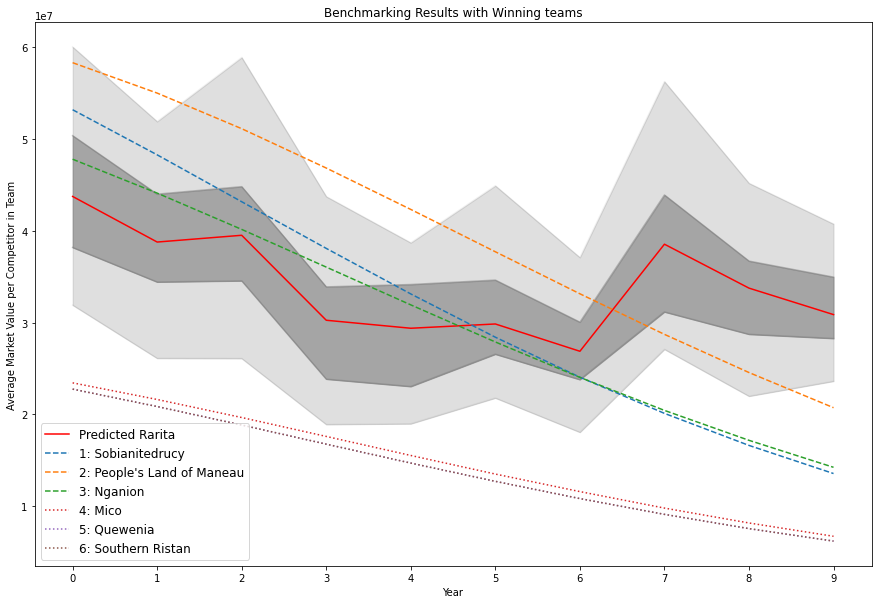

In [262]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)

qs = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
q_mv = np.quantile(rarita_mv, qs, axis=0)

plt.title("Benchmarking Results with Winning teams")
plt.xlabel("Year")
plt.ylabel("Average Market Value per Competitor in Team")
plt.xticks(np.arange(n_time))

plt.plot(np.arange(n_time), q_mv[3, :], color ="red", label = 'Predicted Rarita')

plt.plot(np.arange(n_time), q_mv[2, :], color ="grey", alpha =  0.5)
plt.plot(np.arange(n_time), q_mv[4, :], color ="grey", alpha =  0.5)
plt.fill_between(np.arange(n_time), q_mv[2,:], q_mv[4,:], color = 'grey', alpha =  0.6)


plt.plot(np.arange(n_time), q_mv[0, :], color ="grey",alpha =  0.10)
plt.plot(np.arange(n_time), q_mv[6, :], color ="grey",alpha =  0.10)
plt.fill_between(np.arange(n_time), q_mv[0,:], q_mv[6,:], color = 'grey', alpha =  0.25)

plt.plot(np.arange(n_time), benchmark_mv.loc[1, ["mv0", "mv1", "mv2", "mv3", "mv4", "mv5", "mv6", "mv7", "mv8", "mv9"]], linestyle = "dashed", label = "1: Sobianitedrucy")
plt.plot(np.arange(n_time), benchmark_mv.loc[2, ["mv0", "mv1", "mv2", "mv3", "mv4", "mv5", "mv6", "mv7", "mv8", "mv9"]], linestyle = "dashed", label = "2: People's Land of Maneau")
plt.plot(np.arange(n_time), benchmark_mv.loc[3, ["mv0", "mv1", "mv2", "mv3", "mv4", "mv5", "mv6", "mv7", "mv8", "mv9"]], linestyle = "dashed", label = "3: Nganion")
plt.plot(np.arange(n_time), benchmark_mv.loc[4, ["mv0", "mv1", "mv2", "mv3", "mv4", "mv5", "mv6", "mv7", "mv8", "mv9"]], linestyle = "dotted", label = "4: Mico")
plt.plot(np.arange(n_time), benchmark_mv.loc[5, ["mv0", "mv1", "mv2", "mv3", "mv4", "mv5", "mv6", "mv7", "mv8", "mv9"]], linestyle = "dotted", label = "5: Quewenia")
plt.plot(np.arange(n_time), benchmark_mv.loc[5, ["mv0", "mv1", "mv2", "mv3", "mv4", "mv5", "mv6", "mv7", "mv8", "mv9"]], linestyle = "dotted", label = "6: Southern Ristan")



plt.legend(loc='lower left', prop={'size': 12})
plt.show()

# Budget

In [263]:
# Budget, Lending rev, other rev
income = np.full((n_time, 3), 0)
# Wages, Borrowing Wages, Borrowing Expense, Other Expense
outcome = np.full((n_time, 4), 0)

for variable, val in solution_variables:

    if "Budget" in variable:
        output = income
        i = 0
    elif "Lending Revenue" in variable:
        output = income
        i = 1
    elif "Other Revenue" in variable:
        output = income
        i = 2
    elif "Wages" in variable:
        output = outcome
        i = 0
    elif "Borrowing Wage" in variable:
        output = outcome
        i = 1
    elif "Borrowing Expense" in variable:
        output = outcome
        i = 2
    elif "Other Expenses" in variable:
        output = outcome
        i = 3
    else:
        continue

    values = variable.split("_")
    year = int(values[-1])
    output[year, i] = val/1000


/var/folders/32/t9xqcq814y79bs78xcmy806w0000gn/T/ipykernel_45779/411526550.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(abs(tick/1000))) + "m" for tick in ticks])


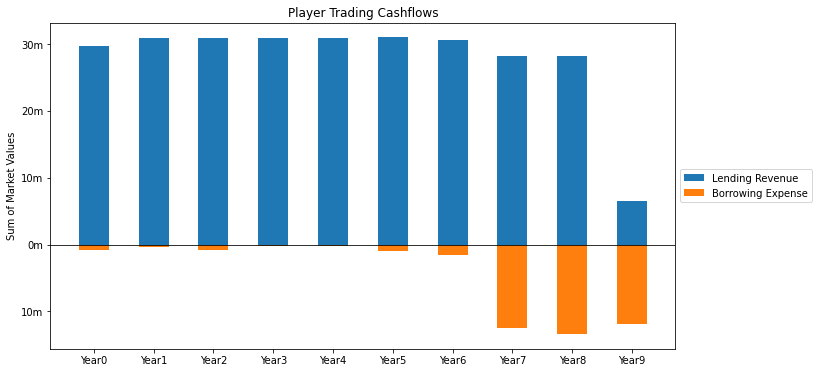

In [264]:
width = 0.5

fig, ax = plt.subplots()

fig.set_figheight(6)
fig.set_figwidth(14)

i_b = income[:, 0]
i_l = income[:, 1]
i_o = income[:, 2]
o_w = -outcome[:, 0]
o_wb = -outcome[:, 1]
o_eb = -outcome[:, 2]
o_e = -outcome[:, 3]

# p1 = ax.bar(years, i_b, width, label='Budget')
p2 = ax.bar(years, i_l, width, label='Lending Revenue')
# p3 = ax.bar(years, i_o, width, label='Other Revenue', bottom=i_b)
# p4 = ax.bar(years, o_w, width, label='Wages')
# p5 = ax.bar(years, o_wb, width, label='Borrowing Wage', bottom=o_w)
p6 = ax.bar(years, o_eb, width, label='Borrowing Expense')
# p7 = ax.bar(years, o_e, width, label='Other Expense')


ax.set_ylabel('Sum of Market Values')
ax.set_title('Player Trading Cashflows')
ax.axhline(0, color='black', linewidth=0.8)

ticks =  ax.get_yticks()
# # set labels to absolute values and with integer representation
ax.set_yticklabels([str(int(abs(tick/1000))) + "m" for tick in ticks])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [265]:
solution_variables

[('assign_11_9', 1.0),
 ('assign_33_0', 1.0),
 ('assign_33_1', 1.0),
 ('assign_33_2', 1.0),
 ('assign_33_3', 1.0),
 ('assign_33_4', 1.0),
 ('assign_33_5', 1.0),
 ('assign_33_6', 1.0),
 ('assign_68_9', 1.0),
 ('assign_103_0', 1.0),
 ('assign_103_1', 1.0),
 ('assign_103_2', 1.0),
 ('assign_103_3', 1.0),
 ('assign_103_4', 1.0),
 ('assign_103_5', 1.0),
 ('assign_103_6', 1.0),
 ('assign_103_7', 1.0),
 ('assign_103_8', 1.0),
 ('assign_103_9', 1.0),
 ('assign_127_7', 1.0),
 ('assign_127_8', 1.0),
 ('assign_127_9', 1.0),
 ('assign_169_7', 1.0),
 ('assign_169_8', 1.0),
 ('assign_169_9', 1.0),
 ('assign_231_7', 1.0),
 ('assign_231_8', 1.0),
 ('assign_231_9', 1.0),
 ('assign_255_3', 1.0),
 ('assign_255_4', 1.0),
 ('assign_255_6', 1.0),
 ('assign_324_0', 1.0),
 ('assign_324_1', 1.0),
 ('assign_324_2', 1.0),
 ('assign_324_3', 1.0),
 ('assign_324_4', 1.0),
 ('assign_324_5', 1.0),
 ('assign_324_6', 1.0),
 ('assign_324_7', 1.0),
 ('assign_393_0', 1.0),
 ('assign_393_1', 1.0),
 ('assign_393_2', 1.0),
 